In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

from torch.utils.data import Dataset, DataLoader, BatchSampler, random_split
from torchvision import transforms
from PIL import Image

In [2]:
# Create Dataset class for multilabel classification
class MultiClassImageDataset(Dataset):
    def __init__(self, ann_df, super_map_df, sub_map_df, img_dir, transform=None):
        self.ann_df = ann_df 
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.ann_df)

    def __getitem__(self, idx):
        img_name = self.ann_df['image'][idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        super_idx = self.ann_df['superclass_index'][idx]
        super_label = self.super_map_df['class'][super_idx]
        
        sub_idx = self.ann_df['subclass_index'][idx]
        sub_label = self.sub_map_df['class'][sub_idx]
        
        if self.transform:
            image = self.transform(image)  
            
        return image, super_idx, super_label, sub_idx, sub_label

class MultiClassImageTestDataset(Dataset):
    def __init__(self, super_map_df, sub_map_df, img_dir, transform=None):
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self): # Count files in img_dir
        return len([fname for fname in os.listdir(self.img_dir)])

    def __getitem__(self, idx):
        img_name = str(idx) + '.jpg'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)  
            
        return image, img_name

In [3]:
# Datasets
train_ann_df = pd.read_csv('train_data.csv')
# test_ann_df = pd.read_csv('test_data.csv')
super_map_df = pd.read_csv('superclass_mapping.csv')
sub_map_df = pd.read_csv('subclass_mapping.csv')

train_img_dir = 'train_images'
test_img_dir = 'test_images'


# Data Augumentation
train_image_processing = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Test transform (no augmentation)
test_image_processing = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#  Improved Dataset Splitting Strategy
# pseudo_novel_superclass = 2 
# pseudo_novel_subclass = 86

# train_mask = ~((train_ann_df['superclass_index'] == pseudo_novel_superclass) |
#                (train_ann_df['subclass_index'] == pseudo_novel_subclass))

# val_mask = ((train_ann_df['superclass_index'] == pseudo_novel_superclass) |
#             (train_ann_df['subclass_index'] == pseudo_novel_subclass))

# train_subset_df = train_ann_df[train_mask].reset_index(drop=True)
# val_subset_df = train_ann_df[val_mask].reset_index(drop=True)

# Rebuild datasets
# train_dataset = MultiClassImageDataset(train_subset_df, super_map_df, sub_map_df, train_img_dir, transform=train_image_processing)
# val_dataset = MultiClassImageDataset(val_subset_df, super_map_df, sub_map_df, train_img_dir, transform=test_image_processing)

# Dataloaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Create train and val split
train_dataset = MultiClassImageDataset(train_ann_df, super_map_df, sub_map_df, train_img_dir, transform=train_image_processing)
train_dataset, val_dataset = random_split(train_dataset, [0.9, 0.1]) 

# Create test dataset
test_dataset = MultiClassImageTestDataset(super_map_df, sub_map_df, test_img_dir, transform=test_image_processing)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        shuffle=True)

test_loader = DataLoader(test_dataset, 
                         batch_size=1, 
                         shuffle=False)

In [4]:

def detect_novel_class(logits, threshold=1.0, novel_index=3):
    energy = torch.logsumexp(logits, dim=1)
    _, predicted_labels = torch.max(logits, dim=1)
    predicted_labels[energy < threshold] = novel_index
    return predicted_labels
# def detect_novel_class_with_softmax(logits, threshold=0.4, novel_index=3):
#     probs = F.softmax(logits, dim=1)
#     max_probs, predicted_labels = torch.max(probs, dim=1)
#     predicted_labels[max_probs < threshold] = novel_index
#     return predicted_labels
# def detect_novel_class_combined(logits, energy_threshold=2.5, prob_threshold=0.4, novel_index=3):
#     energy = torch.logsumexp(logits, dim=1)
#     probs = F.softmax(logits, dim=1)
#     max_probs, predicted_labels = torch.max(probs, dim=1)
#     novel_flags = (energy < energy_threshold) | (max_probs < prob_threshold)
#     predicted_labels[novel_flags] = novel_index
#     return predicted_labels
# def detect_novel_class_entropy(logits, energy_threshold=2.5, entropy_threshold=1.8, novel_index=3):
#     energy = torch.logsumexp(logits, dim=1)
#     probs = F.softmax(logits, dim=1)
#     entropy = -torch.sum(probs * torch.log(probs + 1e-8), dim=1)
    
#     _, predicted_labels = torch.max(logits, dim=1)
#     novel_flags = (energy < energy_threshold) | (entropy > entropy_threshold)
#     predicted_labels[novel_flags] = novel_index
#     return predicted_labels

In [5]:
def tune_energy_threshold(model, val_loader, min_t=0.5, max_t=3.0, step=0.1, device="cpu"):
    best_threshold_super = 1.5
    best_threshold_sub = 2.0
    best_unseen_acc = 0.0

    # Simulate unseen samples in validation set
    for t_super in np.arange(min_t, max_t, step):
        for t_sub in np.arange(min_t, max_t, step):
            unseen_correct = 0
            unseen_total = 0

            with torch.no_grad():
                for images, super_labels, sub_labels in val_loader:
                    images = images.to(device)
                    super_labels = super_labels.to(device)
                    sub_labels = sub_labels.to(device)

                    super_logits, sub_logits = model(images)

                    super_preds = detect_novel_class(super_logits, threshold=t_super, novel_index=3)
                    sub_preds = detect_novel_class(sub_logits, threshold=t_sub, novel_index=87)

                    unseen_mask = super_labels == 3  # ground truth novel superclass
                    unseen_correct += (super_preds[unseen_mask] == super_labels[unseen_mask]).sum().item()
                    unseen_total += unseen_mask.sum().item()

            if unseen_total > 0:
                acc = 100 * unseen_correct / unseen_total
                if acc > best_unseen_acc:
                    best_unseen_acc = acc
                    best_threshold_super = t_super
                    best_threshold_sub = t_sub

    print(f"Best thresholds found: super={best_threshold_super:.2f}, sub={best_threshold_sub:.2f}")
    return best_threshold_super, best_threshold_sub

In [6]:
import torch
import torch.nn as nn
from transformers import CLIPVisionModel, CLIPImageProcessor

class CLIPAdapterModel(nn.Module):
    def __init__(self, num_super=4, num_sub=88):
        super(CLIPAdapterModel, self).__init__()
        
        self.clip = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
        self.processor = CLIPImageProcessor()

        for param in self.clip.parameters():
            param.requires_grad = False

        clip_dim = self.clip.config.hidden_size

        self.super_head = nn.Sequential(
            nn.Linear(clip_dim, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Linear(256, num_super)
        )

        self.sub_head = nn.Sequential(
            nn.Linear(clip_dim, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, num_sub)
        )

    def forward(self, pixel_values):
        outputs = self.clip(pixel_values=pixel_values)
        features = outputs.last_hidden_state[:, 0, :]

        super_logits = self.super_head(features)
        sub_logits = self.sub_head(features)

        return super_logits, sub_logits

/Users/bindumadhavi/Documents/Projects/nndl_project/nndl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
class CLIPTrainer:
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, test_loader=None, device='cuda'):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device

    def train_epoch(self):
        running_loss = 0.0
            
        for i, data in enumerate(self.train_loader):
            images, super_labels, sub_labels = data[0].to(self.device), data[1].to(self.device), data[3].to(self.device)

            self.optimizer.zero_grad()
            super_outputs, sub_outputs = self.model(images)
            loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        print(f"Train Loss: {running_loss / len(self.train_loader):.4f}")

    def validate_epoch(self, energy_threshold_super=1.5, energy_threshold_sub=2.0):
        super_correct = 0
        sub_correct = 0
        total = 0
        running_loss = 0.0

        with torch.no_grad():
            for i, data in enumerate(self.val_loader):
                images, super_labels, sub_labels = data[0].to(self.device), data[1].to(self.device), data[3].to(self.device)

                super_outputs, sub_outputs = self.model(images)

                loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
                super_preds = detect_novel_class(super_outputs, energy_threshold_super, novel_index=3)
                sub_preds = detect_novel_class(sub_outputs, energy_threshold_sub, novel_index=87)

                total += super_labels.size(0)
                super_correct += (super_preds == super_labels).sum().item()
                sub_correct += (sub_preds == sub_labels).sum().item()
                running_loss += loss.item()  

        print(f'Validation loss: {running_loss/i:.3f}')
        print(f"Val Superclass Acc: {100 * super_correct / total:.2f}%")
        print(f"Val Subclass Acc: {100 * sub_correct / total:.2f}%")

    def test(self, save_to_csv=True, return_predictions=False, energy_threshold_super=1.2, energy_threshold_sub=1.3):
        if not self.test_loader:
            raise NotImplementedError('test_loader not specified')

        # Evaluate on test set, in this simple demo no special care is taken for novel/unseen classes
        test_predictions = {'image': [], 'superclass_index': [], 'subclass_index': []}

        with torch.no_grad():
            for i, data in enumerate(self.test_loader):
                images, img_names = data[0].to(self.device), data[1]
                super_outputs, sub_outputs = self.model(images)

                super_preds = detect_novel_class(super_outputs, energy_threshold_super, novel_index=3)
                sub_preds = detect_novel_class(sub_outputs, energy_threshold_sub, novel_index=87)

                test_predictions['image'].append(img_names[0])
                test_predictions['superclass_index'].append(super_preds.item())
                test_predictions['subclass_index'].append(sub_preds.item())

        test_predictions = pd.DataFrame(data=test_predictions)
        if save_to_csv:
            test_predictions.to_csv('example_test_predictions.csv', index=False)
        if return_predictions:
            return test_predictions

In [8]:
import argparse

# Init model and trainer
# parser = argparse.ArgumentParser()
# parser.add_argument('--device', default='cpu', help="Device to run on: 'cpu' or 'cuda'")
# args = parser.parse_args()
# device = args.device

# print("----device------", device)

device = "cpu"
model = CLIPAdapterModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = CLIPTrainer(model, criterion, optimizer, train_loader, val_loader, test_loader, device=device)


In [9]:
class LogitAdjustmentLoss(torch.nn.Module):
    def __init__(self, prior):
        super().__init__()
        self.register_buffer('prior', torch.tensor(prior).log())

    def forward(self, logits, labels):
        adjusted_logits = logits + self.prior.unsqueeze(0)
        return F.cross_entropy(adjusted_logits, labels)

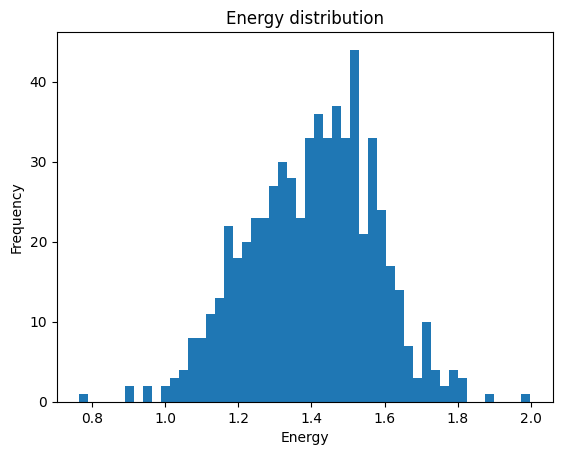

In [10]:
energy_scores = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, _, _, = data[0].to(device), data[1].to(device), data[3].to(device)
        super_outputs, sub_outputs = model(images)
        energy = torch.logsumexp(super_outputs, dim=1)
        energy_scores.extend(energy.cpu().numpy())

plt.hist(energy_scores, bins=50)
plt.title("Energy distribution")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.show()

In [11]:
# Training loop
for epoch in range(20):
    print(f'Epoch {epoch+1}')
    trainer.train_epoch()
    trainer.validate_epoch(energy_threshold_super=1.2, energy_threshold_sub=1.3)

    print('')

print('Finished Training')

Epoch 1
Train Loss: 1.9949
Validation loss: 0.998
Val Superclass Acc: 99.20%
Val Subclass Acc: 75.96%

Epoch 2
Train Loss: 0.7351
Validation loss: 0.691
Val Superclass Acc: 99.04%
Val Subclass Acc: 82.64%

Epoch 3
Train Loss: 0.5639
Validation loss: 0.621
Val Superclass Acc: 99.52%
Val Subclass Acc: 80.73%

Epoch 4
Train Loss: 0.4811
Validation loss: 0.639
Val Superclass Acc: 99.20%
Val Subclass Acc: 79.14%

Epoch 5
Train Loss: 0.4429
Validation loss: 0.493
Val Superclass Acc: 99.68%
Val Subclass Acc: 85.51%

Epoch 6
Train Loss: 0.4028
Validation loss: 0.527
Val Superclass Acc: 99.68%
Val Subclass Acc: 84.71%

Epoch 7
Train Loss: 0.3878
Validation loss: 0.513
Val Superclass Acc: 99.04%
Val Subclass Acc: 83.76%

Epoch 8
Train Loss: 0.3460
Validation loss: 0.475
Val Superclass Acc: 99.36%
Val Subclass Acc: 85.99%

Epoch 9
Train Loss: 0.3444
Validation loss: 0.496
Val Superclass Acc: 99.36%
Val Subclass Acc: 85.35%

Epoch 10
Train Loss: 0.3154
Validation loss: 0.516
Val Superclass Acc: 99

In [12]:
test_predictions = trainer.test(save_to_csv=True, return_predictions=True, energy_threshold_super=1.2, energy_threshold_sub=1.3)
print("\nTest predictions saved to example_test_predictions.csv")


Test predictions saved to example_test_predictions.csv
